# Neural Networks Homework 


**Prathyusha Gayam**

This assignment is due on Moodle by **11:59pm on Wednesday May 2nd**. Submit only this Jupyter notebook to Moodle.  Do not compress it using tar, rar, zip, etc. Your solutions to analysis questions should be done in Markdown directly below the associated question.  Remember that you are encouraged to discuss the problems with your instructors and classmates, but **you must write all code and solutions on your own**.  For a refresher on the course **Collaboration Policy** click [here](https://github.com/chrisketelsen/CSCI5622-Machine-Learning/blob/master/resources/syllabus.md#collaboration-policy)

**NOTES**: 

- Do **NOT** load or use any Python packages that are not available in Anaconda 3.6. 
- Some problems with code may be autograded.  If we provide a function API **do not** change it.  If we do not provide a function API then you're free to structure your code however you like. 
- Submit only this Jupyter notebook to Moodle.  Do not compress it using tar, rar, zip, etc. 

In [1]:
import pickle, gzip
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline

### [30 points] Problem 1: Building and Training a Feed-Forward Neural Network 
***

In this problem you'll implement a general feed-forward neural network class that utilizes sigmoid activation functions. Your tasks will be to implement `forward propagation`, `prediction`, `back propagation`, `gradient_checking`, and a general `train` routine to learn the weights in your network via Stochastic Gradient Descent.  

The skeleton for the `Network` class is below. Note that this class is almost identical to the one you worked with in the **Lecture 18** in-class notebook, so you should look there to remind yourself of the details.   Scroll down to find more information about your tasks as well as unit tests. 

**Important Note**: In **Problem 2** we'll be using the `Network` class to train a network to do handwritten digit recognition.  Please make sure to utilize vectorized Numpy routines as much as possible, as writing inefficient code here will cause very slow training times in **Problem 2**. 

In [2]:
class Network:
    def __init__(self, sizes):
        """
        Initialize the neural network 
        
        :param sizes: a list of the number of neurons in each layer 
        """
        # save the number of layers in the network 
        self.L = len(sizes) 
        
        # store the list of layer sizes 
        self.sizes = sizes  
        
        # initialize the bias vectors for each hidden and output layer 
        self.b = [np.random.randn(n) for n in self.sizes[1:]]
        
        # initialize the matrices of weights for each hidden and output layer 
        self.W = [np.random.randn(n, m) for (m,n) in zip(self.sizes[:-1], self.sizes[1:])]
        
        # initialize the derivatives of biases for backprop 
        self.db = [np.zeros(n) for n in self.sizes[1:]]
        
        # initialize the derivatives of weights for backprop 
        self.dW = [np.zeros((n, m)) for (m,n) in zip(self.sizes[:-1], self.sizes[1:])]
        
        # initialize the activities on each hidden and output layer 
        self.z = [np.zeros(n) for n in self.sizes]
        
        # initialize the activations on each hidden and output layer 
        self.a = [np.zeros(n) for n in self.sizes]
        
        # initialize the deltas on each hidden and output layer 
        self.delta = [np.zeros(n) for n in self.sizes]
        
    def g(self, z):
        """
        sigmoid activation function 
        
        :param z: vector of activities to apply activation to 
        """
        z = np.clip(z, -20, 20)
        return 1.0/(1.0 + np.exp(-z))
    
    def g_prime(self, z):
        """
        derivative of sigmoid activation function 
        
        :param z: vector of activities to apply derivative of activation to 
        """
        return self.g(z) * (1.0 - self.g(z))
    
    def C(self, a, y):
        """
        evaluate the cost function for squared-loss C(a,y) = ||a-y||^2/2 
        
        :param a: activations on output layer 
        :param y: vector-encoded label 
        """
        
        return 0.5 * np.linalg.norm(a - y)**2
    
    def gradC(self, a, y):
        """
        evaluate gradient of cost function for squared-loss C(a,y) = ||a-y||^2/2 
        
        :param a: activations on output layer 
        :param y: vector-encoded label 
        """
        return (a - y)
    
    def forward_prop(self, x):
        """
        take an feature vector and propagate through network 
        
        :param x: input feature vector 
        """
        
        # TODO: Initialize activation on initial layer to x 
        self.a[0] = x
        
        # TODO: Loop over layers and compute activities and activations 
        for i in range(0, self.L-1):
            Wi, bi = self.W[i], self.b[i]
            self.z[i+1] = np.dot(Wi, self.a[i]) + bi
            self.a[i+1] = self.g(self.z[i+1])
        
    def predict(self, X):
        """
        Predicts on the the data in X. Assume at least two output neurons so predictions
        are one-hot encoded vectorized labels. 
        
        :param X: a matrix of data to make predictions on 
        :return y: a matrix of vectorized labels 
        """

        yhat = np.zeros((X.shape[0], self.sizes[-1]), dtype=int)
        
        # TODO: Populate yhat with one-hot-coded predictions 
        for i, xi_train in enumerate(X):
            self.forward_prop(xi_train)
            yhat[i][np.argmax(self.a[-1])] = 1
            
        return yhat;
    
    def accuracy(self, X, y):
        """
        compute accuracy on labeled training set 

        :param X: matrix of features 
        :param y: matrix of vectorized true labels 
        """
        yhat = self.predict(X)
        return np.sum(np.all(np.equal(yhat, y), axis=1)) / X.shape[0]
            
            
    def back_prop(self, x, y):
        """
        Back propagation to get derivatives of C wrt weights and biases for given training example
        
        :param x: training features  
        :param y: vector-encoded label 
        """
        
        # TODO: forward prop training example to fill in activities and activations 
        self.forward_prop(x)
        
        # TODO: compute deltas on output layer 
        self.delta[self.L-1] = np.multiply(self.a[-1] - y, self.g_prime(self.z[-1]))
        
        # TODO: loop backward through layers, backprop deltas, compute dWs and dbs
        for l in range(self.L-2, -1, -1):
            z = self.a[l]
            k = self.delta[l+1]
            
            self.dW[l] = np.multiply(k[:, np.newaxis], z[:, np.newaxis].T)
            self.db[l] = self.delta[l+1]
            
            self.delta[l] = np.multiply(np.dot(self.W[l].T, self.delta[l+1]), 
                                         self.g_prime(self.z[l]))
        
    def gradient_checking(self, X_train, y_train, EPS=0.0001):
        """
        Performs gradient checking on all weights in the 
        network for a randomly selected training example 
        :param X_train: matrix of training features 
        :param y_train: matrix of vector-encoded training labels 
        """
        # Randomly select a training example 
        
        kk = np.random.randint(0,X_train.shape[0])
        xk = X_train[kk]
        yk = y_train[kk]

        # Get the analytic(ish) weights from back_prop 
        self.back_prop(xk, yk)
        
        # List of relative errors.  Used only for unit testing. 
        rel_errors = []

        # Loop over and perturb each weight/bias in 
        # network and test numerical derivative 
        # Don't forget that after perturbing the weights
        # you'll want to put them back the way they were! 
        
        # Loop over and perturb each weight/bias in 
        # network and test numerical derivative 
        for ell in range(self.L-1):
            for ii in range(self.W[ell].shape[0]):
                # Check weights in level W[ell][ii,jj] 
                for jj in range(self.W[ell].shape[1]):
                    
                    # TODO true_dW  
                    true_dW = self.dW[ell][ii][jj]
                    
                    # TODO num_dW
                    temp = self.W[ell][ii][jj]
            
                    self.W[ell][ii][jj] = temp + EPS
                    self.forward_prop(xk)
                    plus_loss = self.C(self.a[-1], yk)
                    
                    self.W[ell][ii][jj] = temp - EPS
                    self.forward_prop(xk)
                    minus_loss = self.C(self.a[-1], yk)
                    
                    self.W[ell][ii][jj] = temp
                    
                    num_dW = (plus_loss - minus_loss)/(2 * EPS)
                    
                    rel_dW = np.abs(true_dW-num_dW)/np.abs(true_dW)
                    print("W[{:d}][{:d},{:d}]: true: {: 12.10e}  approx: {: 12.10e} rel_err: {: 12.10e}".format(ell, ii, jj, true_dW, num_dW, rel_dW))
                    rel_errors.append(rel_dW)
                    
                # Check bias b[ell][ii]
                
                # TODO true_db
                true_db = self.db[ell][ii]
                
                # TODO num_db 
                temp = self.b[ell][ii]
                
                self.b[ell][ii] = temp + EPS
                self.forward_prop(xk)
                plus_loss_b = self.C(self.a[-1], yk)
                
                self.b[ell][ii] = temp - EPS
                self.forward_prop(xk)
                minus_loss_b = self.C(self.a[-1], yk)
                
                num_db = (plus_loss_b - minus_loss_b)/(2 * EPS)
                self.b[ell][ii] = temp
                
                rel_db = np.abs(true_db-num_db)/np.abs(true_db)
                print("b[{:d}][{:d}]:   true: {: 12.10e}  approx: {: 12.10e} rel_err: {: 12.10e}".format(ell, ii, true_db, num_db, rel_db))
                rel_errors.append(rel_db)

        return rel_errors
            
    def train(self, X_train, y_train, X_valid=None, y_valid=None, eta=0.25, lam=0.0, num_epochs=10, isPrint=True):
        """
        Train the network with SGD 
        
        :param X_train: matrix of training features 
        :param y_train: matrix of vector-encoded training labels 
        :param X_valid: optional matrix of validation features 
        :param y_valid: optional matrix of vector-encoded validation labels 
        :param eta: learning rate 
        :param lam: regularization strength 
        :param num_epochs: number of epochs to run 
        :param isPrint: flag indicating to print training progress or not 
        """
        result = []
        # initialize shuffled indices 
        shuffled_inds = list(range(X_train.shape[0]))
        
        # loop over training epochs 
        for ep in range(1, num_epochs+1):
            
            # shuffle indices 
            np.random.shuffle(shuffled_inds)
            
            # loop over training examples 
            for ind in shuffled_inds:
                
                # TODO: back prop to get derivatives 
                self.back_prop(X_train[ind], y_train[ind])
                self.W = self.W - np.multiply(eta, self.dW) - np.multiply(self.W,lam*eta)
                self.b = self.b - np.multiply(eta, self.db)
                
            if isPrint and ((ep+1)%5)==1:
                self.epoch_report(ep, num_epochs, X_train, y_train, X_valid, y_valid)
    
            if ((ep+1)%5)==1:
                r = {"epoch":ep+1, "train_acc":self.accuracy(X_train, y_train)}
                if X_valid is not None:
                    r['valid_acc'] = self.accuracy(X_valid, y_valid)
                result.append(r)
    
        # print final accuracy
        if isPrint:
            self.epoch_report(ep, num_epochs, X_train, y_train, X_valid, y_valid)
            
        r = {"epoch":ep+1, "train_acc":self.accuracy(X_train, y_train)}
        
        if X_valid is not None:
            r['valid_acc'] = self.accuracy(X_valid, y_valid)
        result.append(r)
        
        return result       
    
    def epoch_report(self, ep, num_epochs, X_train, y_train, X_valid, y_valid):
        """
        Print the accuracy for the given epoch on training and validation data 
        
        :param ep: the current epoch 
        :param num_epochs: the total number of epochs
        :param X_train: matrix of training features 
        :param y_train: matrix of vector-encoded training labels 
        :param X_valid: optional matrix of validation features 
        :param y_valid: optional matrix of vector-encoded validation labels 
        """
        print("epoch {:3d}/{:3d}: ".format(ep, num_epochs), end="")
        print("  train acc: {:8.3f}".format(self.accuracy(X_train, y_train)), end="")
        if X_valid is not None: 
            print("  valid acc: {:8.3f}".format(self.accuracy(X_valid, y_valid)))
        else: print("")   
    

**Part A**: Complete the `forward_prop` function in the `Network` class to implement forward propagation.  Your function should take in a single training example `x` and propagate it forward in the network, setting the activations and activities on the hidden and output layers.  When you think you're done, execute the following unit test. 

In [3]:
%run -i nn_tests.py "prob 1A"

testForwardProp (__main__.TestNN) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


**Part B**: Complete the `predict` function in the `Network` class to take in a matrix of features and return a matrix of one-hot-encoded label predictions. Your one-hot-encoded predictions should correspond to the output neuron with the largest activation.   

When you think your `predict` function is working well, execute the following unit test. 

In [4]:
%run -i nn_tests.py "prob 1B"

testPredict (__main__.TestNN) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.003s

OK


**Part C**: OK, now it's time to implement back propagation.  Complete the function ``back_prop`` in the ``Network`` class to use a single training example to compute the derivatives of the loss function with respect to the weights and the biases. As in the **Lecture 18** in-class notebook, you may assume that the loss function for a single training example is given by 

$$
C(y, {\bf a}^L) = \frac{1}{2}\|y - {\bf a}^L\|^2  
$$

When you think you're done, execute the following unit test. 

In [5]:
%run -i nn_tests.py "prob 1C"

testBackProp (__main__.TestNN) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.004s

OK


**Part D**: Due to the fact that we hard-code our various activation functions, cost functions, and their derivatives, it is vital to do some debugging to make sure we haven't made a mistake.  

One common technique is to do **numerical gradient checking**.  In this method we compute numerical approximations of the derivatives of the cost function with respect to the model parameters and compare them to the analytic versions computed by back prop.  

Consider a cost function $C$ which is a function of all of the weights and biases in the network.  We can estimate the derivative of $C$ with respect to a particular parameter using a numerical finite difference technique.  This process looks as follows 

$$
\frac{\partial C}{\partial w_i} \approx \frac{C(w_1,\ldots, w_i+\epsilon, \ldots w_N) - C(w_1,\ldots, w_i-\epsilon, \ldots w_N)}{2\epsilon}
$$

Evaluating the cost function with the perturbed weights can be accomplished by randomly choosing a training example, performing forward propagation, and then evaluating the cost function using the activations in the output layer.  

I've given you starter code down below to do numerical gradient checking.  The code will compute the true and numerical values of the derivative of $C$ with respect to each parameter in the network and then plot the pairs of values as well as their relative errors.  Note that in practice this is extremely expensive, and we typically only check a few random parameters. 

When you believe your code is correct, you can test it by executing the following cell. Note that a good rule of thumb is to train the network for a handful of epochs before doing the gradient checking, to avoid any transient behavior that might occur at the very beginning of the training process. 

In [6]:
%run -i nn_tests.py "prob 1D"

testGradCheck (__main__.TestNN) ... 

W[0][0,0]: true: -1.6129176665e-02  approx: -1.6129176655e-02 rel_err:  6.2758809415e-10
W[0][0,1]: true: -3.2258353331e-02  approx: -3.2258353251e-02 rel_err:  2.4817827221e-09
b[0][0]:   true: -1.6129176665e-02  approx: -1.6129176655e-02 rel_err:  6.2758809415e-10
W[0][1,0]: true:  1.0259238746e-02  approx:  1.0259238739e-02 rel_err:  6.6307893984e-10
W[0][1,1]: true:  2.0518477492e-02  approx:  2.0518477439e-02 rel_err:  2.5974560468e-09
b[0][1]:   true:  1.0259238746e-02  approx:  1.0259238739e-02 rel_err:  6.6307893984e-10
W[0][2,0]: true: -5.1903568015e-04  approx: -5.1903567999e-04 rel_err:  3.0985203531e-10
W[0][2,1]: true: -1.0380713603e-03  approx: -1.0380713582e-03 rel_err:  2.0477984656e-09
b[0][2]:   true: -5.1903568015e-04  approx: -5.1903567999e-04 rel_err:  3.0985203531e-10
W[1][0,0]: true: -7.1372985374e-02  approx: -7.1372985357e-02 rel_err:  2.3383240182e-10
W[1][0,1]: true: -4.3055527018e-02  approx: -4.3055527015e-02 rel_err:  8.6212384741e-11
W[1][0,2]: true: -7.8

ok

----------------------------------------------------------------------
Ran 1 test in 0.007s

OK


**Part E**: OK, now let's actually train a neural net!  Complete the missing code in ``train`` to loop over the training data in random order, call `back_prop` to get the derivatives, and then update the weights and the biases via SGD.  When you think you're done, execute the following code

In [7]:
%run -i nn_tests.py "prob 1E"

testSGD (__main__.TestNN) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.004s

OK


**Part F**: Last but not least, we should implement $\ell$-$2$ regularization.  Modify your `train` function to incorporate regularization of the weights (but **not** the biases) in your SGD update.  As in the Lecture 18 slides, you should assume that the cost function with regularization takes the form 

$$
C_\lambda = C + \frac{\lambda}{2} \displaystyle\sum_{w} w^2
$$

where $\sum_{w}$ sums over each weight in all layers of the network. Think carefully before you go making large changes to your code.  This modification is much simpler than you think. When you think you're done, execute the following unit test.  (Then go back and execute the test in **Part C** to make sure you didn't break anything.) 

In [8]:
%run -i nn_tests.py "prob 1F"

testRegularizedSGD (__main__.TestNN) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.006s

OK


### [20 points] Problem 2: A Neural Network Classifier for Handwritten Digit Recognition 
***

In this problem you'll use the Feed-Forward Neural Network framework you wrote in **Problem 1** to take an image of a handwritten digit and predict which digit it corresponds to.  

![Samples of Handwritten Digits](mnist.png "MNIST Digits")

To keep run times down we'll again only consider the subset of the MNIST data set consisting of the digits $3, 7, 8$ and $9$. 

**Part A**: Executing the following cells will load training and validation data and plot an example handwritten digit.  Explore the training and validation sets and answer the following questions: 

- How many pixels are in each image in the data set?  
- How do the true labels correspond to the associated one-hot-encoded label vectors? 
- Give an example of a network architecture with a single hidden layer that is compatible with this data. 


In [9]:
X_train, y_train, X_valid, y_valid = pickle.load(gzip.open("../data/mnist21x21_3789_one_hot.pklz", "rb"))

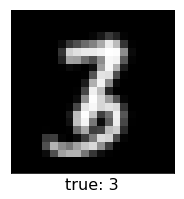

In [10]:
def view_digit(x, label=None):
    fig = plt.figure(figsize=(3,3))
    plt.imshow(x.reshape(21,21), cmap='gray');
    plt.xticks([]); plt.yticks([]);
    if label: plt.xlabel("true: {}".format(label), fontsize=16)
        
training_index = 2
label_dict = dict({0:3, 1:7, 2:8, 3:9})
view_digit(X_train[training_index], label_dict[np.argmax(y_train[training_index])])

In [11]:
print(len(X_train[0]), "pixels in each image")

441 pixels in each image


One hot encoding for 3:  [1 0 0 0]
One hot encoding for 7:  [0 1 0 0]
One hot encoding for 8:  [0 0 1 0]
One hot encoding for 9:  [0 0 0 1]


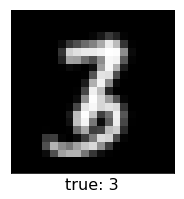

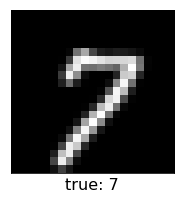

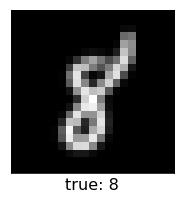

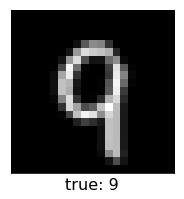

In [12]:
view_digit(X_train[2], label_dict[np.argmax(y_train[2])])
print("One hot encoding for 3: ", y_train[2])
view_digit(X_train[0], label_dict[np.argmax(y_train[0])])
print("One hot encoding for 7: ", y_train[0])
view_digit(X_train[5], label_dict[np.argmax(y_train[5])])
print("One hot encoding for 8: ", y_train[5])
view_digit(X_train[1], label_dict[np.argmax(y_train[1])])
print("One hot encoding for 9: ", y_train[1])

Network architecture with a single hidden layer that is compatible with the data is [441, 50, 4]

No. of neurons in the input layer = 441
No. of neurons in the output layer = 4
number of hidden layers and no. of neurons in hidden layers can vary and each guves a different accuracy

**Part B**: Train a network with a single hidden layer containing $30$ neurons on the first $500$ training examples in the training set using a learning rate of $\eta = 0.01$ for at least $50$ epochs.  What accuracy does your network achieve on the validation set?  Do you see any clear signs of overfitting?   

In [14]:
nn = Network([441,30,4])
nn.train(X_train[0:500], y_train[0:500], X_valid, 
              y_valid, eta=0.01, num_epochs=70, isPrint=True)

epoch   5/ 70:   train acc:    0.354  valid acc:    0.364
epoch  10/ 70:   train acc:    0.470  valid acc:    0.495
epoch  15/ 70:   train acc:    0.568  valid acc:    0.587
epoch  20/ 70:   train acc:    0.650  valid acc:    0.659
epoch  25/ 70:   train acc:    0.704  valid acc:    0.720
epoch  30/ 70:   train acc:    0.750  valid acc:    0.763
epoch  35/ 70:   train acc:    0.782  valid acc:    0.795
epoch  40/ 70:   train acc:    0.814  valid acc:    0.803
epoch  45/ 70:   train acc:    0.840  valid acc:    0.818
epoch  50/ 70:   train acc:    0.850  valid acc:    0.839
epoch  55/ 70:   train acc:    0.864  valid acc:    0.846
epoch  60/ 70:   train acc:    0.878  valid acc:    0.849
epoch  65/ 70:   train acc:    0.888  valid acc:    0.855
epoch  70/ 70:   train acc:    0.890  valid acc:    0.862
epoch  70/ 70:   train acc:    0.890  valid acc:    0.862


[{'epoch': 6, 'train_acc': 0.354, 'valid_acc': 0.364},
 {'epoch': 11, 'train_acc': 0.47, 'valid_acc': 0.495},
 {'epoch': 16, 'train_acc': 0.568, 'valid_acc': 0.587},
 {'epoch': 21, 'train_acc': 0.65, 'valid_acc': 0.659},
 {'epoch': 26, 'train_acc': 0.704, 'valid_acc': 0.72},
 {'epoch': 31, 'train_acc': 0.75, 'valid_acc': 0.763},
 {'epoch': 36, 'train_acc': 0.782, 'valid_acc': 0.795},
 {'epoch': 41, 'train_acc': 0.814, 'valid_acc': 0.803},
 {'epoch': 46, 'train_acc': 0.84, 'valid_acc': 0.818},
 {'epoch': 51, 'train_acc': 0.85, 'valid_acc': 0.839},
 {'epoch': 56, 'train_acc': 0.864, 'valid_acc': 0.846},
 {'epoch': 61, 'train_acc': 0.878, 'valid_acc': 0.849},
 {'epoch': 66, 'train_acc': 0.888, 'valid_acc': 0.855},
 {'epoch': 71, 'train_acc': 0.89, 'valid_acc': 0.862},
 {'epoch': 71, 'train_acc': 0.89, 'valid_acc': 0.862}]

Accuracy on validation set is 85.9% for 70 epochs and there are no clear signs of overfitting as we can see both train and validation accuracy are improving with epochs. The training accuracy is 89.8% which is greater than validation accuracy

**Part C**: Modify the `Network` class so that it stores the accuracies on the training and validation data every $5$ epochs during the training process. Now increase the number of neurons in the hidden layer to $100$.  On a single set of axes, plot the **validation accuracy** vs epoch for networks trained on the full training set for at least 50 epochs using the learning rates $\eta = 0.01$, $\eta = 0.25$ and $\eta = 1.5$.  Which learning rate seems to perform the best? What is the best accuracy achieved on the validation set?   

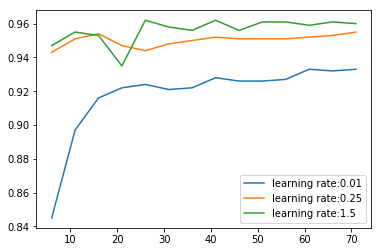

In [15]:
etas = [0.01, 0.25, 1.5]
colors = ["red", "green", "blue"]

nn = Network([441,100,4])

for eta in etas:
    result = nn.train(X_train, y_train, X_valid, y_valid, eta=eta, num_epochs=70, isPrint=False)
    x, y = [], []
    for r in result:
        x.append(r['epoch'])
        y.append(r['valid_acc'])
    plt.plot(x, y, label='learning rate:{}'.format(eta))
    plt.legend()
    
plt.show()

**Learning rate of 1.5 seems to perform the best with a best accuracy of approximatley 96%**

**Part D**:  Now let's see if we can get better results with regularization. Using the best learning rate you found in **Part C**, on a single set of axes, plot the **validation accuracy** vs epoch for networks trained on the full training set for at least 50 epochs using the regularization strengths $\lambda = 10^{-6}$, $\lambda = 10^{-4}$ and $\lambda = 10^{-2}$.  Which regularization strength seems to perform the best? What is the best accuracy achieved on the validation set?   

In [16]:
best_learning_rate = 1.5

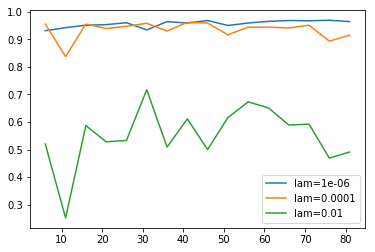

In [17]:
lams = [1e-6, 1e-4, 1e-2]
nn = Network([441,100,4])
for lam in lams:
    result = nn.train(X_train, y_train, X_valid, y_valid, eta=best_learning_rate, lam=lam, num_epochs=80, isPrint=False)
    x, y = [], []
    for r in result:
        x.append(r['epoch'])
        y.append(r['valid_acc'])
    plt.plot(x, y, label='lam={}'.format(lam))
    plt.legend()

plt.show()

**lam = 1e-6 performed best with the best accuracy of 97-98% on the validation data set**

**Part E**:  Now let's see if we can get better results with different network architectures. On a single set of axes, plot the **validation accuracy** vs epoch for networks trained on the full training set for at least 50 epochs using the architecture from **Part D** as well as two other architectures.  Which architecture seems to perform the best? What is the best accuracy achieved on the validation set?   

In [18]:
best_lam = 1e-6

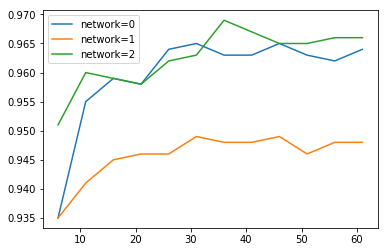

In [19]:
nn1 = Network([441,100,4])
nn2 = Network([441,50,50,4])
nn3 = Network([441,50,50,50,4])

for i, n in enumerate([nn1, nn2, nn3]):
    result = n.train(X_train, y_train, X_valid, y_valid, eta=0.25, lam=best_lam, num_epochs=60, isPrint=False)
    x, y = [], []
    for r in result:
        x.append(r['epoch'])
        y.append(r['valid_acc'])
    plt.plot(x, y, label='network={}'.format(i))
    plt.legend()

plt.show()

**Among the 3 networks the network with more number of hidden layers seem to work the best than the networks with 1 and 2 layers. The best accuracy achieved on the validation set is 97% for 40 epochs and at 60 epochs the best accuracy is 96.5%**

### [max 20 points] Extra Credit: Improving Network Performance 
***

See if you can get better performance by exploring advanced techniques.  Things you might try are: 

- Implementing **Mini-Batch** Stochastic Gradient Descent 
- Experimenting with different activation functions (like tanh and **Leaky** ReLU)
- Experimenting with different loss functions (like cross-entropy) 

For more detailed discussion of these techniques it'll be helpful to look at Chapter 3 of [Nielsen](http://neuralnetworksanddeeplearning.com/chap3.html). 

The amount of extra credit you receive will be proportional to the number of above suggested tasks that you complete.  Further, to receive credit for the tasks you must not only implement, but also provide evidence that you've tuned the network to make it work.  Comment on the performance differences between the original `Network` implementation and your new networks with bells and whistles. 

**Important Note**: Don't do any of these things in the original `Network` class, because you'll almost certainly break the unit tests.  Copy the `Network` class from above and rename it `BetterNetwork` (or something) and modify the new class. 


In [20]:
class BetterNetwork:
    def __init__(self, sizes):
        """
        Initialize the neural network 
        
        :param sizes: a list of the number of neurons in each layer 
        """
        # save the number of layers in the network 
        self.L = len(sizes) 
        
        # store the list of layer sizes 
        self.sizes = sizes  
        
        # initialize the bias vectors for each hidden and output layer 
        self.b = [np.random.randn(n) for n in self.sizes[1:]]
        
        # initialize the matrices of weights for each hidden and output layer 
        self.W = [np.random.randn(n, m) for (m,n) in zip(self.sizes[:-1], self.sizes[1:])]
        
        # initialize the derivatives of biases for backprop 
        self.db = [np.zeros(n) for n in self.sizes[1:]]
        
        # initialize the derivatives of weights for backprop 
        self.dW = [np.zeros((n, m)) for (m,n) in zip(self.sizes[:-1], self.sizes[1:])]
        
        # initialize the activities on each hidden and output layer 
        self.z = [np.zeros(n) for n in self.sizes]
        
        # initialize the activations on each hidden and output layer 
        self.a = [np.zeros(n) for n in self.sizes]
        
        # initialize the deltas on each hidden and output layer 
        self.delta = [np.zeros(n) for n in self.sizes]
        
    def g(self, z):
        """
        tanh activation function 
        
        """
        z = np.clip(z, -20, 20)
        return (np.exp(-2*z) - 1)/(np.exp(-2*z)+1)
    
    def g_prime(self, z):
        
        """
        derivative of tanh function 
        
        """
        return (1.0 - self.g(z)) * (1.0 - self.g(z))
    
    def C(self, a, y):
        """
        evaluate the cost function for cross entropy 
        """
        if a == 1:
            return -log(y)
        else:
            return -log(1 - y)
    
    def gradC(self, a, y):
        """
        evaluate gradient of cost function for cross entropy
        """
        if a == 1:
            return -1.0/y
        else:
            return 1.0/(1.0 - y)
    
    def forward_prop(self, x):
        """
        take an feature vector and propagate through network 
        
        :param x: input feature vector 
        """
        
        # TODO: Initialize activation on initial layer to x 
        self.a[0] = x
        
        # TODO: Loop over layers and compute activities and activations 
        for i in range(0, self.L-1):
            Wi, bi = self.W[i], self.b[i]
            self.z[i+1] = np.dot(Wi, self.a[i]) + bi
            self.a[i+1] = self.g(self.z[i+1])
        
    def predict(self, X):
        """
        Predicts on the the data in X. Assume at least two output neurons so predictions
        are one-hot encoded vectorized labels. 
        
        :param X: a matrix of data to make predictions on 
        :return y: a matrix of vectorized labels 
        """

        yhat = np.zeros((X.shape[0], self.sizes[-1]), dtype=int)
        
        # TODO: Populate yhat with one-hot-coded predictions 
        for i, xi_train in enumerate(X):
            self.forward_prop(xi_train)
            yhat[i][np.argmax(self.a[-1])] = 1
            
        return yhat;
    
    def accuracy(self, X, y):
        """
        compute accuracy on labeled training set 

        :param X: matrix of features 
        :param y: matrix of vectorized true labels 
        """
        yhat = self.predict(X)
        return np.sum(np.all(np.equal(yhat, y), axis=1)) / X.shape[0]
            
            
    def back_prop(self, x, y):
        """
        Back propagation to get derivatives of C wrt weights and biases for given training example
        
        :param x: training features  
        :param y: vector-encoded label 
        """
        
        # TODO: forward prop training example to fill in activities and activations 
        self.forward_prop(x)
        
        # TODO: compute deltas on output layer 
        self.delta[self.L-1] = np.multiply(self.a[-1] - y, self.g_prime(self.z[-1]))
        
        # TODO: loop backward through layers, backprop deltas, compute dWs and dbs
        for l in range(self.L-2, -1, -1):
            z = self.a[l]
            k = self.delta[l+1]
            
            self.dW[l] = np.multiply(k[:, np.newaxis], z[:, np.newaxis].T)
            self.db[l] = self.delta[l+1]
            
            self.delta[l] = np.multiply(np.dot(self.W[l].T, self.delta[l+1]), 
                                         self.g_prime(self.z[l]))
  
            
    def train(self, X_train, y_train, X_valid=None, y_valid=None, eta=0.25, lam=0.0, num_epochs=10, isPrint=True):
        """
        Train the network with SGD 
        
        :param X_train: matrix of training features 
        :param y_train: matrix of vector-encoded training labels 
        :param X_valid: optional matrix of validation features 
        :param y_valid: optional matrix of vector-encoded validation labels 
        :param eta: learning rate 
        :param lam: regularization strength 
        :param num_epochs: number of epochs to run 
        :param isPrint: flag indicating to print training progress or not 
        """
        result = []
        # initialize shuffled indices 
        shuffled_inds = list(range(X_train.shape[0]))
        
        # loop over training epochs 
        for ep in range(1, num_epochs+1):
            
            # shuffle indices 
            np.random.shuffle(shuffled_inds)
            
            # loop over training examples 
            for ind in shuffled_inds:
                
                # TODO: back prop to get derivatives 
                self.back_prop(X_train[ind], y_train[ind])
                self.W = self.W - np.multiply(eta, self.dW) - np.multiply(self.W,lam*eta)
                self.b = self.b - np.multiply(eta, self.db)
                
            if isPrint and ((ep+1)%5)==1:
                self.epoch_report(ep, num_epochs, X_train, y_train, X_valid, y_valid)
    
            if ((ep+1)%5)==1:
                r = {"epoch":ep+1, "train_acc":self.accuracy(X_train, y_train)}
                if X_valid is not None:
                    r['valid_acc'] = self.accuracy(X_valid, y_valid)
                result.append(r)
    
        # print final accuracy
        if isPrint:
            self.epoch_report(ep, num_epochs, X_train, y_train, X_valid, y_valid)
            
        r = {"epoch":ep+1, "train_acc":self.accuracy(X_train, y_train)}
        
        if X_valid is not None:
            r['valid_acc'] = self.accuracy(X_valid, y_valid)
        result.append(r)
        
        return result       
    
    def epoch_report(self, ep, num_epochs, X_train, y_train, X_valid, y_valid):
        """
        Print the accuracy for the given epoch on training and validation data 
        
        :param ep: the current epoch 
        :param num_epochs: the total number of epochs
        :param X_train: matrix of training features 
        :param y_train: matrix of vector-encoded training labels 
        :param X_valid: optional matrix of validation features 
        :param y_valid: optional matrix of vector-encoded validation labels 
        """
        print("epoch {:3d}/{:3d}: ".format(ep, num_epochs), end="")
        print("  train acc: {:8.3f}".format(self.accuracy(X_train, y_train)), end="")
        if X_valid is not None: 
            print("  valid acc: {:8.3f}".format(self.accuracy(X_valid, y_valid)))
        else: print("")   
    

In [21]:
X_train, y_train, X_valid, y_valid = pickle.load(gzip.open("../data/mnist21x21_3789_one_hot.pklz", "rb"))

In [25]:
better_nn = BetterNetwork([441,50,50,50,4])
better_nn.train(X_train, y_train, X_valid, 
              y_valid, eta=0.01, num_epochs=70, isPrint=True)

epoch   5/ 70:   train acc:    0.191  valid acc:    0.195
epoch  10/ 70:   train acc:    0.191  valid acc:    0.195
epoch  15/ 70:   train acc:    0.191  valid acc:    0.195
epoch  20/ 70:   train acc:    0.191  valid acc:    0.195
epoch  25/ 70:   train acc:    0.191  valid acc:    0.195
epoch  30/ 70:   train acc:    0.191  valid acc:    0.195
epoch  35/ 70:   train acc:    0.191  valid acc:    0.195
epoch  40/ 70:   train acc:    0.191  valid acc:    0.195
epoch  45/ 70:   train acc:    0.191  valid acc:    0.195
epoch  50/ 70:   train acc:    0.191  valid acc:    0.195
epoch  55/ 70:   train acc:    0.191  valid acc:    0.195
epoch  60/ 70:   train acc:    0.191  valid acc:    0.195
epoch  65/ 70:   train acc:    0.191  valid acc:    0.195
epoch  70/ 70:   train acc:    0.191  valid acc:    0.195
epoch  70/ 70:   train acc:    0.191  valid acc:    0.195


[{'epoch': 6, 'train_acc': 0.19075, 'valid_acc': 0.195},
 {'epoch': 11, 'train_acc': 0.19075, 'valid_acc': 0.195},
 {'epoch': 16, 'train_acc': 0.19075, 'valid_acc': 0.195},
 {'epoch': 21, 'train_acc': 0.19075, 'valid_acc': 0.195},
 {'epoch': 26, 'train_acc': 0.19075, 'valid_acc': 0.195},
 {'epoch': 31, 'train_acc': 0.19075, 'valid_acc': 0.195},
 {'epoch': 36, 'train_acc': 0.19075, 'valid_acc': 0.195},
 {'epoch': 41, 'train_acc': 0.19075, 'valid_acc': 0.195},
 {'epoch': 46, 'train_acc': 0.19075, 'valid_acc': 0.195},
 {'epoch': 51, 'train_acc': 0.19075, 'valid_acc': 0.195},
 {'epoch': 56, 'train_acc': 0.19075, 'valid_acc': 0.195},
 {'epoch': 61, 'train_acc': 0.19075, 'valid_acc': 0.195},
 {'epoch': 66, 'train_acc': 0.19075, 'valid_acc': 0.195},
 {'epoch': 71, 'train_acc': 0.19075, 'valid_acc': 0.195},
 {'epoch': 71, 'train_acc': 0.19075, 'valid_acc': 0.195}]